In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
file_path = './data/modelnet40_ply_hdf5_2048/ply_data_train0.h5'
with h5py.File(file_path, 'r') as file:
    label = file['label']
    data_dataset = file['data']
    data_labels  = label[:]
    data_values = data_dataset[:]
point_cloud = np.expand_dims(data_values, -1)

class network(tf.keras.Model):
    def __init__(self):
        super().__init__()
        K=3
        self.input_conv1 = tf.keras.layers.Conv2D(64, (1, 3), (1, 1), padding='valid', activation='relu')
        self.input_conv2 = tf.keras.layers.Conv2D(128, (1, 1), (1, 1), padding='valid', activation='relu')
        self.input_conv3 = tf.keras.layers.Conv2D(1024, (1, 1), (1, 1), padding='valid', activation='relu')
        self.input_maxpooling2d = tf.keras.layers.MaxPooling2D(pool_size=(1024, 1), padding='valid')
        self.input_flatten = tf.keras.layers.Flatten()
        self.input_dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.input_dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.input_dense3 = tf.keras.layers.Dense(3*K, activation=None)
        self.model_1_conv1 = tf.keras.layers.Conv2D(64, (1, 3), (1, 1), padding='valid', activation='relu')
        self.model_1_conv2 = tf.keras.layers.Conv2D(64, (1, 1), (1, 1), padding='valid', activation='relu')
        K = 64
        self.feature_conv1 = tf.keras.layers.Conv2D(64, (1, 1), (1, 1), padding='valid', activation='relu')
        self.feature_conv2 = tf.keras.layers.Conv2D(128, (1, 1), (1, 1), padding='valid', activation='relu')
        self.feature_conv3 = tf.keras.layers.Conv2D(1024, (1, 1), (1, 1), padding='valid', activation='relu')
        self.feature_maxpooling2d = tf.keras.layers.MaxPooling2D(pool_size=(1024, 1), padding='valid')
        self.feature_flatten = tf.keras.layers.Flatten()
        self.feature_dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.feature_dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.feature_dense3 = tf.keras.layers.Dense(K*K, activation=None)
        self.model_2_conv1 = tf.keras.layers.Conv2D(64, (1, 1), (1, 1), padding='valid', activation='relu')
        self.model_2_conv2 = tf.keras.layers.Conv2D(128, (1, 1), (1, 1), padding='valid', activation='relu')
        self.model_2_conv3 = tf.keras.layers.Conv2D(1024, (1, 1), (1, 1), padding='valid', activation='relu')
        self.model_2_maxpooling2d = tf.keras.layers.MaxPooling2D(pool_size=(1024, 1), padding='valid')
        self.model_2_flatten = tf.keras.layers.Flatten()
        self.model_2_dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.model_2_dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.model_2_dense3 = tf.keras.layers.Dense(40, activation=None)

    def call(self, inputs):
        y = self.input_conv1(inputs)
        y = self.input_conv2(y)
        y = self.input_conv3(y)
        y = self.input_maxpooling2d(y)
        y = self.input_flatten(y)
        y = self.input_dense1(y)
        y = self.input_dense2(y)
        y = self.input_dense3(y)
        transform = tf.reshape(y, (-1, 3, 3))
        x = tf.matmul(tf.squeeze(inputs, axis=[3]), transform)
        x = tf.expand_dims(x, -1)
        x = self.model_1_conv1(x)
        x = self.model_1_conv2(x)
        y = self.feature_conv1(x)
        y = self.feature_conv2(y)
        y = self.feature_conv3(y)
        y = self.feature_maxpooling2d(y)
        y = self.feature_flatten(y)
        y = self.feature_dense1(y)
        y = self.feature_dense2(y)
        y = self.feature_dense3(y)
        transform = tf.reshape(y, (-1, 64, 64))
        x = tf.matmul(tf.squeeze(x, axis=[2]), transform)
        x = tf.expand_dims(x, [2])
        x = self.model_2_conv1(x)
        x = self.model_2_conv2(x)
        x = self.model_2_conv3(x)
        x = self.model_2_maxpooling2d(x)
        x = self.model_2_flatten(x)
        x = self.model_2_dense1(x)
        x = self.model_2_dense2(x)
        x = self.model_2_dense3(x)
        return x

# class project:
#     def __init__(self):
#         self.model = network()
#     def train(self):
#         model_params = self.model.trainable

model = network()
model.build(input_shape=(None, 2048, 3, 1))
model.summary()
print("simple_v2.py, line 109")
optimizer = Adam(learning_rate=0.00003)

def train(max_iteration):
    losses = []
    accuracies = []
    model_params = model.trainable_variables
    num_batches = len(point_cloud) // 32
    for iteration in range(max_iteration):
        total_loss = []
        total_accuracy = []
        with tqdm(total=num_batches, desc=f'iteration {iteration + 1}', unit='batch') as pbar:
            for i in range(0, len(point_cloud), 32):
                batch_size=32
                point_cloud_batch = point_cloud[i:i+batch_size]
                with tf.GradientTape() as tape:
                    tape.watch(model_params)
                    y = model(point_cloud_batch)
                    
                    labels = tf.one_hot([data_labels[i:i+batch_size]], 40)
                    loss = tf.reduce_mean(tf.square(tf.squeeze(labels, axis=[0, 2]) - y))
                    y_pred = tf.argmax(y, axis=1)
                    labels_pred = tf.argmax(tf.squeeze(labels, axis=[0, 2]), axis=1)
                    accuracy = tf.reduce_mean(tf.cast(tf.equal(labels_pred, y_pred), dtype=tf.float32))
                grads = tape.gradient(loss, model_params)
                optimizer.apply_gradients(zip(grads, model_params))
                pbar.update(1)
                pbar.set_postfix({'Loss': loss.numpy()})

                total_loss.append(loss)
                total_accuracy.append(accuracy)
        
        iteration_loss = np.mean(np.array(total_loss))
        iteration_accuracy = np.mean(np.array(total_accuracy))
        print(f'Iteration {iteration + 1}, Loss: {iteration_loss:.5f}, Accuracy: {iteration_accuracy:.5f}')
        losses.append(iteration_loss)
        accuracies.append(iteration_accuracy)
    return losses, accuracies

Model: "network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  256       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  8320      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  132096    
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1049088   
_________________________________________________________________
dense_1 (Dense)              multiple                  1313

2024-03-26 21:20:18.990801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-26 21:20:18.993588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-26 21:20:18.993734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-26 21:20:18.993995: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

iteration 1:   0%|          | 0/64 [00:00<?, ?batch/s]2024-03-26 21:20:20.342684: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2024-03-26 21:20:21.092257: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
iteration 1: 100%|██████████| 64/64 [00:03<00:00, 18.90batch/s, Loss=0.0246]


Iteration 1, Loss: 0.02483, Accuracy: 0.06641


iteration 2: 100%|██████████| 64/64 [00:02<00:00, 29.89batch/s, Loss=0.0241]


Iteration 2, Loss: 0.02437, Accuracy: 0.06006


iteration 3: 100%|██████████| 64/64 [00:02<00:00, 29.91batch/s, Loss=0.0239]


Iteration 3, Loss: 0.02406, Accuracy: 0.09131


iteration 4: 100%|██████████| 64/64 [00:02<00:00, 29.99batch/s, Loss=0.0237]


Iteration 4, Loss: 0.02392, Accuracy: 0.12305


iteration 5: 100%|██████████| 64/64 [00:02<00:00, 29.97batch/s, Loss=0.0235]


Iteration 5, Loss: 0.02364, Accuracy: 0.14551


iteration 6: 100%|██████████| 64/64 [00:02<00:00, 29.97batch/s, Loss=0.0233]


Iteration 6, Loss: 0.02328, Accuracy: 0.15771


iteration 7: 100%|██████████| 64/64 [00:02<00:00, 29.76batch/s, Loss=0.0229]


Iteration 7, Loss: 0.02291, Accuracy: 0.16016


iteration 8: 100%|██████████| 64/64 [00:02<00:00, 29.75batch/s, Loss=0.0217]


Iteration 8, Loss: 0.02228, Accuracy: 0.20166


iteration 9: 100%|██████████| 64/64 [00:02<00:00, 29.73batch/s, Loss=0.0199]


Iteration 9, Loss: 0.02115, Accuracy: 0.29639


iteration 10: 100%|██████████| 64/64 [00:02<00:00, 29.70batch/s, Loss=0.0182]


Iteration 10, Loss: 0.01990, Accuracy: 0.36035


iteration 11: 100%|██████████| 64/64 [00:02<00:00, 29.73batch/s, Loss=0.0168]


Iteration 11, Loss: 0.01894, Accuracy: 0.39941


iteration 12: 100%|██████████| 64/64 [00:02<00:00, 29.77batch/s, Loss=0.0158]


Iteration 12, Loss: 0.01819, Accuracy: 0.42139


iteration 13: 100%|██████████| 64/64 [00:02<00:00, 29.76batch/s, Loss=0.015] 


Iteration 13, Loss: 0.01752, Accuracy: 0.44287


iteration 14: 100%|██████████| 64/64 [00:02<00:00, 29.75batch/s, Loss=0.0145]


Iteration 14, Loss: 0.01693, Accuracy: 0.47266


iteration 15: 100%|██████████| 64/64 [00:02<00:00, 29.82batch/s, Loss=0.014] 


Iteration 15, Loss: 0.01639, Accuracy: 0.49268


iteration 16: 100%|██████████| 64/64 [00:02<00:00, 29.56batch/s, Loss=0.0136]


Iteration 16, Loss: 0.01590, Accuracy: 0.51855


iteration 17: 100%|██████████| 64/64 [00:02<00:00, 29.70batch/s, Loss=0.0133]


Iteration 17, Loss: 0.01547, Accuracy: 0.54102


iteration 18: 100%|██████████| 64/64 [00:02<00:00, 29.66batch/s, Loss=0.0131]


Iteration 18, Loss: 0.01509, Accuracy: 0.56934


iteration 19: 100%|██████████| 64/64 [00:02<00:00, 29.63batch/s, Loss=0.0128]


Iteration 19, Loss: 0.01476, Accuracy: 0.58838


iteration 20: 100%|██████████| 64/64 [00:02<00:00, 29.59batch/s, Loss=0.0127]


Iteration 20, Loss: 0.01446, Accuracy: 0.60352


iteration 21: 100%|██████████| 64/64 [00:02<00:00, 29.54batch/s, Loss=0.0125]


Iteration 21, Loss: 0.01419, Accuracy: 0.62256


iteration 22: 100%|██████████| 64/64 [00:02<00:00, 29.57batch/s, Loss=0.0123] 


Iteration 22, Loss: 0.01393, Accuracy: 0.63330


iteration 23: 100%|██████████| 64/64 [00:02<00:00, 29.64batch/s, Loss=0.0122] 


Iteration 23, Loss: 0.01370, Accuracy: 0.64258


iteration 24: 100%|██████████| 64/64 [00:02<00:00, 29.49batch/s, Loss=0.0121] 


Iteration 24, Loss: 0.01348, Accuracy: 0.64893


iteration 25: 100%|██████████| 64/64 [00:02<00:00, 29.31batch/s, Loss=0.012]  


Iteration 25, Loss: 0.01326, Accuracy: 0.65820


iteration 26: 100%|██████████| 64/64 [00:02<00:00, 29.33batch/s, Loss=0.0118] 


Iteration 26, Loss: 0.01307, Accuracy: 0.66602


iteration 27: 100%|██████████| 64/64 [00:02<00:00, 29.33batch/s, Loss=0.0117] 


Iteration 27, Loss: 0.01288, Accuracy: 0.67480


iteration 28: 100%|██████████| 64/64 [00:02<00:00, 29.31batch/s, Loss=0.0116] 


Iteration 28, Loss: 0.01270, Accuracy: 0.68652


iteration 29: 100%|██████████| 64/64 [00:02<00:00, 29.38batch/s, Loss=0.0115] 


Iteration 29, Loss: 0.01253, Accuracy: 0.69580


iteration 30: 100%|██████████| 64/64 [00:02<00:00, 29.31batch/s, Loss=0.0114] 


Iteration 30, Loss: 0.01236, Accuracy: 0.70508


iteration 31: 100%|██████████| 64/64 [00:02<00:00, 29.34batch/s, Loss=0.0113] 


Iteration 31, Loss: 0.01221, Accuracy: 0.71143


iteration 32: 100%|██████████| 64/64 [00:02<00:00, 29.37batch/s, Loss=0.0112] 


Iteration 32, Loss: 0.01205, Accuracy: 0.71777


iteration 33: 100%|██████████| 64/64 [00:02<00:00, 29.40batch/s, Loss=0.0112] 


Iteration 33, Loss: 0.01191, Accuracy: 0.72656


iteration 34: 100%|██████████| 64/64 [00:02<00:00, 29.36batch/s, Loss=0.0111] 


Iteration 34, Loss: 0.01177, Accuracy: 0.73096


iteration 35: 100%|██████████| 64/64 [00:02<00:00, 29.32batch/s, Loss=0.011]  


Iteration 35, Loss: 0.01163, Accuracy: 0.73828


iteration 36: 100%|██████████| 64/64 [00:02<00:00, 29.43batch/s, Loss=0.0109] 


Iteration 36, Loss: 0.01150, Accuracy: 0.74170


iteration 37: 100%|██████████| 64/64 [00:02<00:00, 29.48batch/s, Loss=0.0108] 


Iteration 37, Loss: 0.01138, Accuracy: 0.74512


iteration 38: 100%|██████████| 64/64 [00:02<00:00, 29.45batch/s, Loss=0.0108] 


Iteration 38, Loss: 0.01126, Accuracy: 0.75146


iteration 39: 100%|██████████| 64/64 [00:02<00:00, 29.47batch/s, Loss=0.0107] 


Iteration 39, Loss: 0.01114, Accuracy: 0.75732


iteration 40: 100%|██████████| 64/64 [00:02<00:00, 29.37batch/s, Loss=0.0106] 


Iteration 40, Loss: 0.01102, Accuracy: 0.75928


iteration 41: 100%|██████████| 64/64 [00:02<00:00, 29.31batch/s, Loss=0.0106] 


Iteration 41, Loss: 0.01090, Accuracy: 0.76270


iteration 42: 100%|██████████| 64/64 [00:02<00:00, 29.24batch/s, Loss=0.0105] 


Iteration 42, Loss: 0.01079, Accuracy: 0.76904


iteration 43: 100%|██████████| 64/64 [00:02<00:00, 29.37batch/s, Loss=0.0104] 


Iteration 43, Loss: 0.01068, Accuracy: 0.77100


iteration 44: 100%|██████████| 64/64 [00:02<00:00, 29.23batch/s, Loss=0.0104] 


Iteration 44, Loss: 0.01058, Accuracy: 0.77441


iteration 45: 100%|██████████| 64/64 [00:02<00:00, 29.22batch/s, Loss=0.0103] 


Iteration 45, Loss: 0.01048, Accuracy: 0.77539


iteration 46: 100%|██████████| 64/64 [00:02<00:00, 29.33batch/s, Loss=0.0103] 


Iteration 46, Loss: 0.01038, Accuracy: 0.77832


iteration 47: 100%|██████████| 64/64 [00:02<00:00, 29.32batch/s, Loss=0.0102] 


Iteration 47, Loss: 0.01028, Accuracy: 0.78027


iteration 48: 100%|██████████| 64/64 [00:02<00:00, 29.31batch/s, Loss=0.0101] 


Iteration 48, Loss: 0.01020, Accuracy: 0.78369


iteration 49: 100%|██████████| 64/64 [00:02<00:00, 29.27batch/s, Loss=0.0101] 


Iteration 49, Loss: 0.01012, Accuracy: 0.78564


iteration 50: 100%|██████████| 64/64 [00:02<00:00, 29.20batch/s, Loss=0.0101] 


Iteration 50, Loss: 0.01004, Accuracy: 0.78662


iteration 51: 100%|██████████| 64/64 [00:02<00:00, 29.30batch/s, Loss=0.01]   


Iteration 51, Loss: 0.00997, Accuracy: 0.78760


iteration 52: 100%|██████████| 64/64 [00:02<00:00, 29.37batch/s, Loss=0.01]   


Iteration 52, Loss: 0.00989, Accuracy: 0.78955


iteration 53: 100%|██████████| 64/64 [00:02<00:00, 29.29batch/s, Loss=0.00996]


Iteration 53, Loss: 0.00983, Accuracy: 0.79297


iteration 54: 100%|██████████| 64/64 [00:02<00:00, 29.28batch/s, Loss=0.00991]


Iteration 54, Loss: 0.00976, Accuracy: 0.79785


iteration 55: 100%|██████████| 64/64 [00:02<00:00, 29.21batch/s, Loss=0.00988]


Iteration 55, Loss: 0.00969, Accuracy: 0.80029


iteration 56: 100%|██████████| 64/64 [00:02<00:00, 29.31batch/s, Loss=0.00986]


Iteration 56, Loss: 0.00962, Accuracy: 0.80127


iteration 57: 100%|██████████| 64/64 [00:02<00:00, 29.22batch/s, Loss=0.00979]


Iteration 57, Loss: 0.00957, Accuracy: 0.80420


iteration 58: 100%|██████████| 64/64 [00:02<00:00, 29.18batch/s, Loss=0.00974]


Iteration 58, Loss: 0.00950, Accuracy: 0.80859


iteration 59: 100%|██████████| 64/64 [00:02<00:00, 29.26batch/s, Loss=0.00968]


Iteration 59, Loss: 0.00943, Accuracy: 0.81201


iteration 60: 100%|██████████| 64/64 [00:02<00:00, 29.33batch/s, Loss=0.00963]


Iteration 60, Loss: 0.00936, Accuracy: 0.81445


iteration 61: 100%|██████████| 64/64 [00:02<00:00, 29.34batch/s, Loss=0.00955]


Iteration 61, Loss: 0.00929, Accuracy: 0.81641


iteration 62: 100%|██████████| 64/64 [00:02<00:00, 29.37batch/s, Loss=0.00949]


Iteration 62, Loss: 0.00923, Accuracy: 0.81787


iteration 63: 100%|██████████| 64/64 [00:02<00:00, 29.39batch/s, Loss=0.00944]


Iteration 63, Loss: 0.00917, Accuracy: 0.81934


iteration 64: 100%|██████████| 64/64 [00:02<00:00, 29.40batch/s, Loss=0.00937]


Iteration 64, Loss: 0.00912, Accuracy: 0.82080


iteration 65: 100%|██████████| 64/64 [00:02<00:00, 29.37batch/s, Loss=0.00934]


Iteration 65, Loss: 0.00906, Accuracy: 0.82422


iteration 66: 100%|██████████| 64/64 [00:02<00:00, 29.36batch/s, Loss=0.00928]


Iteration 66, Loss: 0.00900, Accuracy: 0.82861


iteration 67: 100%|██████████| 64/64 [00:02<00:00, 29.24batch/s, Loss=0.00924]


Iteration 67, Loss: 0.00895, Accuracy: 0.82910


iteration 68: 100%|██████████| 64/64 [00:02<00:00, 29.20batch/s, Loss=0.00921]


Iteration 68, Loss: 0.00890, Accuracy: 0.83008


iteration 69: 100%|██████████| 64/64 [00:02<00:00, 29.04batch/s, Loss=0.00913]


Iteration 69, Loss: 0.00885, Accuracy: 0.83105


iteration 70: 100%|██████████| 64/64 [00:02<00:00, 29.07batch/s, Loss=0.00909]


Iteration 70, Loss: 0.00879, Accuracy: 0.83154


iteration 71: 100%|██████████| 64/64 [00:02<00:00, 29.10batch/s, Loss=0.00904]


Iteration 71, Loss: 0.00874, Accuracy: 0.83203


iteration 72: 100%|██████████| 64/64 [00:02<00:00, 29.19batch/s, Loss=0.00904]


Iteration 72, Loss: 0.00870, Accuracy: 0.83398


iteration 73: 100%|██████████| 64/64 [00:02<00:00, 29.23batch/s, Loss=0.009]  


Iteration 73, Loss: 0.00866, Accuracy: 0.83691


iteration 74: 100%|██████████| 64/64 [00:02<00:00, 29.30batch/s, Loss=0.00897]


Iteration 74, Loss: 0.00862, Accuracy: 0.83740


iteration 75: 100%|██████████| 64/64 [00:02<00:00, 29.24batch/s, Loss=0.00897]


Iteration 75, Loss: 0.00860, Accuracy: 0.83984


iteration 76: 100%|██████████| 64/64 [00:02<00:00, 29.25batch/s, Loss=0.00894]


Iteration 76, Loss: 0.00859, Accuracy: 0.84033


iteration 77: 100%|██████████| 64/64 [00:02<00:00, 29.24batch/s, Loss=0.00881]


Iteration 77, Loss: 0.00855, Accuracy: 0.84131


iteration 78: 100%|██████████| 64/64 [00:02<00:00, 29.25batch/s, Loss=0.00874]


Iteration 78, Loss: 0.00851, Accuracy: 0.84277


iteration 79: 100%|██████████| 64/64 [00:02<00:00, 29.24batch/s, Loss=0.00871]


Iteration 79, Loss: 0.00845, Accuracy: 0.84473


iteration 80: 100%|██████████| 64/64 [00:02<00:00, 29.31batch/s, Loss=0.00864]


Iteration 80, Loss: 0.00840, Accuracy: 0.85107


iteration 81: 100%|██████████| 64/64 [00:02<00:00, 29.14batch/s, Loss=0.00858]


Iteration 81, Loss: 0.00832, Accuracy: 0.85645


iteration 82: 100%|██████████| 64/64 [00:02<00:00, 29.06batch/s, Loss=0.00853]


Iteration 82, Loss: 0.00827, Accuracy: 0.85840


iteration 83: 100%|██████████| 64/64 [00:02<00:00, 29.12batch/s, Loss=0.00846]


Iteration 83, Loss: 0.00820, Accuracy: 0.86084


iteration 84: 100%|██████████| 64/64 [00:02<00:00, 29.14batch/s, Loss=0.00841]


Iteration 84, Loss: 0.00813, Accuracy: 0.86035


iteration 85: 100%|██████████| 64/64 [00:02<00:00, 29.01batch/s, Loss=0.00837]


Iteration 85, Loss: 0.00807, Accuracy: 0.86230


iteration 86: 100%|██████████| 64/64 [00:02<00:00, 29.11batch/s, Loss=0.00831]


Iteration 86, Loss: 0.00802, Accuracy: 0.86475


iteration 87: 100%|██████████| 64/64 [00:02<00:00, 29.34batch/s, Loss=0.00826]


Iteration 87, Loss: 0.00797, Accuracy: 0.86523


iteration 88: 100%|██████████| 64/64 [00:02<00:00, 29.30batch/s, Loss=0.00823]


Iteration 88, Loss: 0.00791, Accuracy: 0.86572


iteration 89: 100%|██████████| 64/64 [00:02<00:00, 29.28batch/s, Loss=0.0082] 


Iteration 89, Loss: 0.00785, Accuracy: 0.86768


iteration 90: 100%|██████████| 64/64 [00:02<00:00, 29.29batch/s, Loss=0.00814]


Iteration 90, Loss: 0.00780, Accuracy: 0.86768


iteration 91: 100%|██████████| 64/64 [00:02<00:00, 29.28batch/s, Loss=0.0081] 


Iteration 91, Loss: 0.00775, Accuracy: 0.86963


iteration 92: 100%|██████████| 64/64 [00:02<00:00, 29.30batch/s, Loss=0.00808]


Iteration 92, Loss: 0.00770, Accuracy: 0.87207


iteration 93: 100%|██████████| 64/64 [00:02<00:00, 29.30batch/s, Loss=0.00802]


Iteration 93, Loss: 0.00766, Accuracy: 0.87158


iteration 94: 100%|██████████| 64/64 [00:02<00:00, 29.17batch/s, Loss=0.00797]


Iteration 94, Loss: 0.00760, Accuracy: 0.87305


iteration 95: 100%|██████████| 64/64 [00:02<00:00, 29.28batch/s, Loss=0.00793]


Iteration 95, Loss: 0.00755, Accuracy: 0.87305


iteration 96: 100%|██████████| 64/64 [00:02<00:00, 29.26batch/s, Loss=0.0079] 


Iteration 96, Loss: 0.00751, Accuracy: 0.87598


iteration 97: 100%|██████████| 64/64 [00:02<00:00, 29.24batch/s, Loss=0.00784]


Iteration 97, Loss: 0.00747, Accuracy: 0.87549


iteration 98: 100%|██████████| 64/64 [00:02<00:00, 29.20batch/s, Loss=0.00783]


Iteration 98, Loss: 0.00742, Accuracy: 0.87842


iteration 99: 100%|██████████| 64/64 [00:02<00:00, 29.21batch/s, Loss=0.00779]


Iteration 99, Loss: 0.00739, Accuracy: 0.88086


iteration 100: 100%|██████████| 64/64 [00:02<00:00, 29.16batch/s, Loss=0.00777]


Iteration 100, Loss: 0.00734, Accuracy: 0.88232


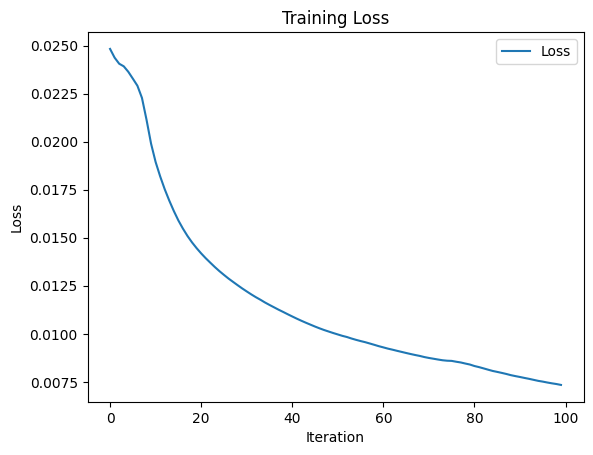

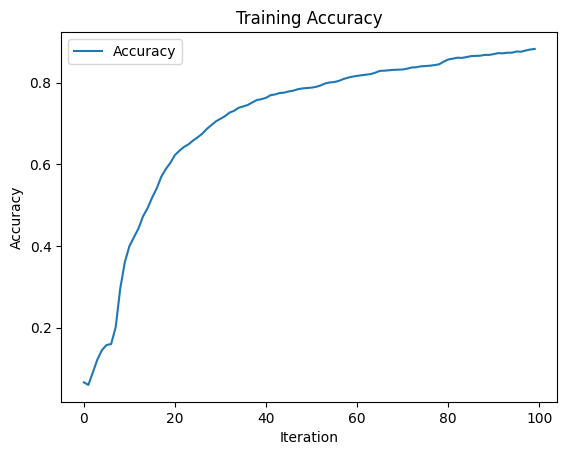

In [2]:
max_iteration = 100
losses, accuracies = train(max_iteration)

# 손실 그래프 그리기
plt.plot(losses, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# 정확도 그래프 그리기
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

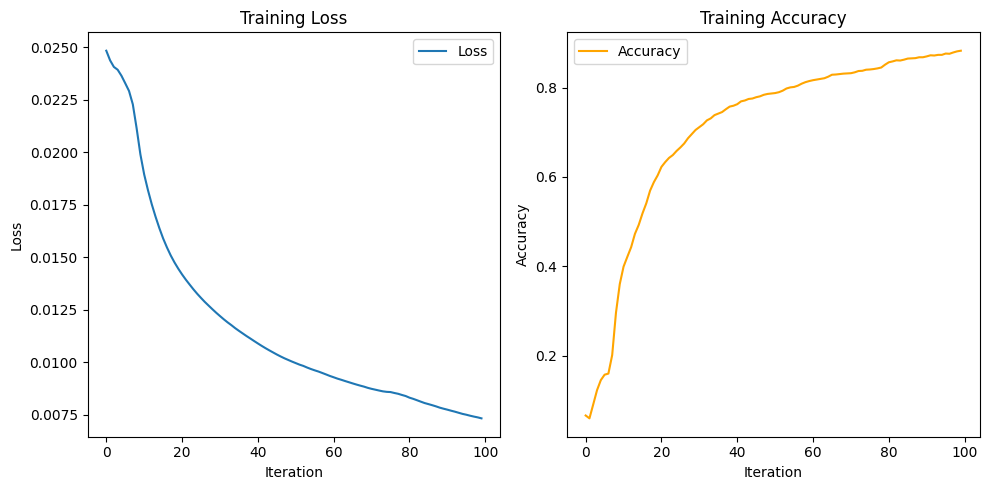

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, color='orange', label='Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()